In [1]:
!pip install stable-baselines3 sb3-contrib --quiet
# !pip install --upgrade jupyter_client --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/HFT-RL/src/envs  /content/

Mounted at /content/drive


In [1]:
import polars as pl
import pandas as pd

import stable_baselines3
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from envs.env import TradingEnv
import pandas as pd

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### *Loading Data*

*Based on NASDAQ Technical 100 Stock LOB*  
*Duration - 2025-05-04 to 2025-06-04*  
*Time Interval - 1 minute*

In [2]:
df = pl.read_csv("/content/drive/MyDrive/HFT-RL/data/USATECHIDXUSD_mt5_ticks_2.csv")

# Convert Timestamp column to datetime
df_with_datetime = df.with_columns(
    pl.col("Timestamp").str.strptime(pl.Datetime, format=
    "%Y%m%d %H:%M:%S:%3f").alias("datetime")
)

df = df_with_datetime.drop("Timestamp")
df = df.to_pandas()
test_df = df[int(len(df)*0.90):]
train_df = df[:int(len(df)*0.90)]
print(len(train_df))

4665987


In [3]:
train_df.head(5)

,Bid price,Ask price,Bid volume,Ask volume,datetime
0,20046.264,20049.768,0.00009,0.00012,2025-05-04 22:06:23.548
1,20046.109,20049.492,0.00009,0.00012,2025-05-04 22:06:23.698
2,20046.121,20049.647,0.00009,0.00012,2025-05-04 22:06:23.849
3,20046.109,20049.579,0.00009,0.00012,2025-05-04 22:06:24.149
4,20046.154,20049.647,0.00009,0.00012,2025-05-04 22:06:24.750


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
env = TradingEnv(df=train_df,
                 initial_cash = 50000,
                 transaction_rate = 0.001,
                 episode_length = 1000)

obs, info = env.reset()

done = False
step_count = 0
while not done:
    # Select a random action from the action space
    random_action = env.action_space.sample()

    obs, reward, terminated, truncated, info = env.step(random_action)
    done = terminated or truncated
    step_count += 1

    # Optional: Render the state to see what's happening
    # env.render()

print(f"✅ Environment ran successfully for {step_count} random steps!")
print(f"Final Info: {info}")

✅ Environment ran successfully for 1000 random steps!
Final Info: {'cash': np.float64(2469.895986699955), 'inventory': 2.3000000000000007, 'position_dir': 1, 'entry_price': None, 'net_worth': np.float64(48581.613886699975), 'action': np.int64(1), 'Tracker_Cash_in_hand': [50000, np.float64(52002.6217736), np.float64(49995.667624400005), np.float64(47988.6979597), np.float64(47988.6979597), np.float64(49991.308744300004), np.float64(47984.325766300004), np.float64(49986.999787600005), np.float64(47980.012305100005), np.float64(45973.026224), np.float64(45973.026224), np.float64(43965.9053082), np.float64(41958.7989069), np.float64(43961.5605405), np.float64(45964.3356606), np.float64(43957.2224525), np.float64(43957.2224525), np.float64(41950.1081433), np.float64(43952.888657999996), np.float64(43952.888657999996), np.float64(45955.675766099994), np.float64(43948.55595139999), np.float64(41941.47187239999), np.float64(41941.47187239999), np.float64(39934.39990549999), np.float64(37927.31

{'cash': np.float64(49991.3434655), 'inventory': 0, 'position_dir': 0, 'entry_price': None, 'net_worth': np.float64(49991.3434655), 'action': np.int64(0), 'Tracker_Cash_in_hand': [50000, 50000, 50000, 50000, np.float64(47993.0371421), np.float64(49995.6479267), np.float64(47988.6649487), np.float64(47988.6649487), np.float64(47988.6649487), np.float64(47988.6649487), np.float64(49991.3434655)], 'Tracker_Net_worth': [50000, np.float64(50000.0), np.float64(50000.0), np.float64(50000.0), np.float64(49997.8215421), np.float64(49995.6479267), np.float64(49993.465548700005), np.float64(49993.517148700004), np.float64(49993.4755487), np.float64(49993.483748700004), np.float64(49991.3434655)], 'Tracker_Inventory': [0.0, 0, 0, 0, 0.1, 0, 0.1, 0.1, 0.1, 0.1, 0]}
-0.00017313068999996175


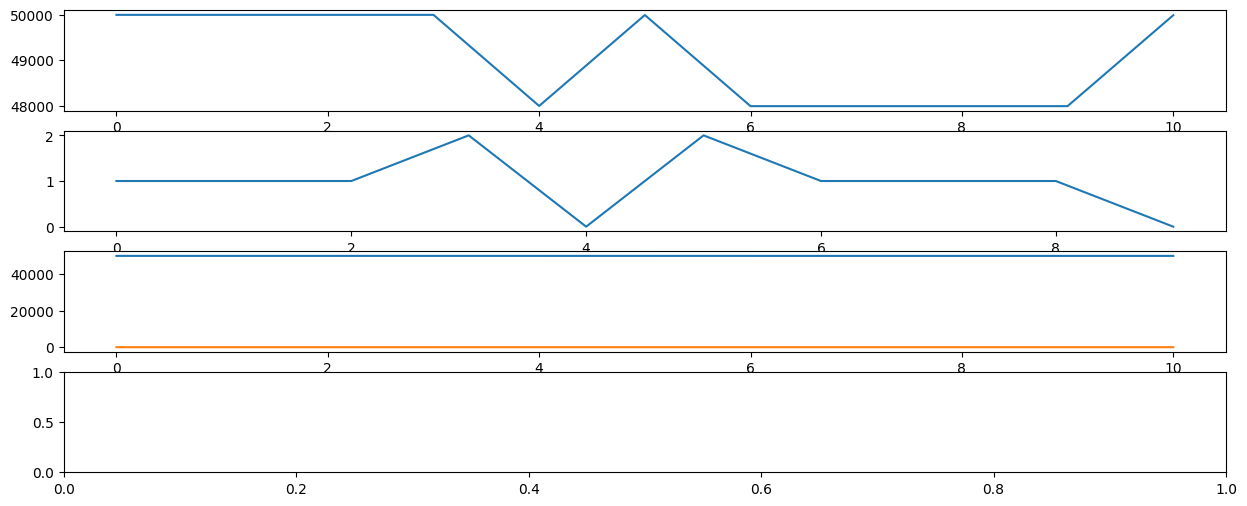

In [7]:
env = TradingEnv(df=train_df,
                 initial_cash = 50000,
                 transaction_rate = 0.001,
                 episode_length = 10)
obs, info = env.reset()
tracker = {}
portfolio_value = env.initial_cash
tracker['Net_worth'] = [portfolio_value]
tracker['action'] = []
done, truncated = False, False
step_count = 0

while not (done or truncated):
    action = env.action_space.sample()
    tracker["action"].append(action)
    obs, reward, done, truncated, info = env.step(action)
    tracker['Net_worth'].append(info["net_worth"])
    step_count += 1

    # print(f"Step {step_count} | Action: {action} | Reward: {reward:.4f} | "
    #       f"Cash: {info['cash']:.2f} | Inv: {info['inventory']} | NetWorth: {info['net_worth']:.2f}")

print(info)
print(reward)
fig, ax = plt.subplots(4,1, figsize = (15,6))
ax[0].plot(info['Tracker_Cash_in_hand'])
ax[1].plot(tracker["action"])
ax[2].plot(info['Tracker_Net_worth'])
ax[2].plot(info['Tracker_Inventory'])
plt.show()

info {'cash': np.float64(20644.471297200103), 'inventory': -0.5999999999999998, 'position_dir': -1, 'entry_price': None, 'net_worth': np.float64(8615.327497200107), 'action': np.int64(0), 'Tracker_Cash_in_hand': [10000, 10000, np.float64(12002.6062891), np.float64(9995.6366244), np.float64(11998.2429135), np.float64(11998.2429135), np.float64(9991.2599355), np.float64(11993.9339568), np.float64(13996.568018099999), np.float64(15999.219861599999), np.float64(18001.898378399997), np.float64(18001.898378399997), np.float64(20004.6512208), np.float64(20004.6512208), np.float64(20004.6512208), np.float64(22007.4363309), np.float64(20000.332131799998), np.float64(17993.217822599996), np.float64(19995.998337299996), np.float64(19995.998337299996), np.float64(21998.785445399997), np.float64(19991.665630699998), np.float64(19991.665630699998), np.float64(17984.575845999996), np.float64(15977.503879099995), np.float64(17980.235542699997), np.float64(17980.235542699997), np.float64(15973.22263479

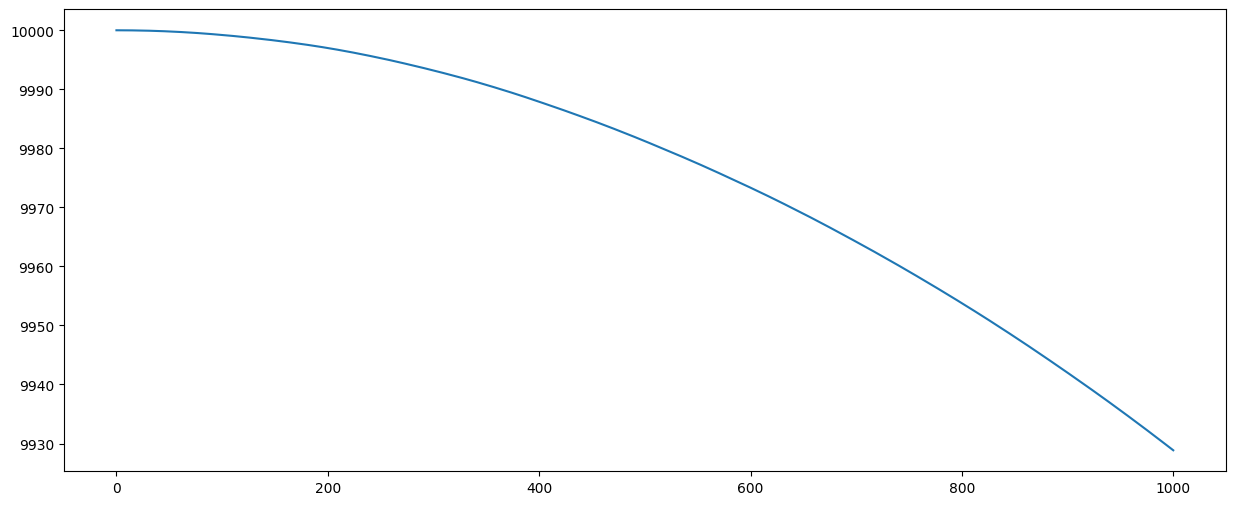

In [6]:
env = TradingEnv(df)
state = env.reset()
portfolio_value = env.initial_cash
tracker = [portfolio_value]
while True:
    action = env.action_space.sample()  # Random action
    n_state, reward, done, _, info = env.step(action)
    portfolio_value += reward
    tracker.append(portfolio_value)
    if done:
        print("info", info)
        break
plt.figure(figsize = (15,6))
plt.plot(tracker, label='Portfolio Value')
# env.render_all()
plt.show()

In [ ]:
# from your_env_file import TradingEnv  # replace with actual file/module import

env = TradingEnv(df, initial_cash=20000, episode_length=len(df))

obs, info = env.reset()
print("RESET:", info)

for step in range(len(df)):
    action = 2 if step == 0 else 1  # open long on step 0, then hold
    obs, reward, done, truncated, info = env.step(action)
    print(f"Step {step} | Action {action} | "
          f"Cash: {info['cash']:.2f} | Inv: {info['inventory']} | "
          f"Price: {env.current_price:.2f} | NetWorth: {info['net_worth']:.2f} | "
          f"Reward: {reward:.4f}")

    if done:
        break

In [8]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO

# vec_env = DummyVecEnv([lambda: TradingEnv(df, episode_length=100000)])
# policy_kwargs = dict(
#     net_arch=[64, 64],
#     activation_fn="relu",
# )
# model = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1)
# model.learn(total_timesteps=100000)


In [9]:
vec_env = DummyVecEnv([lambda: TradingEnv(train_df, episode_length=len(train_df))])  # Shorter episodes




model = PPO('MultiInputPolicy',env=vec_env,verbose=1,gamma=0.99,
            ent_coef=0.03,learning_rate=3e-4,
            policy_kwargs=dict(net_arch=[64,64]),device='cpu', batch_size=128)













# # Use a larger network
# policy_kwargs = dict(
#     net_arch=[128, 128],
#     activation_fn="tanh",  # Try different activation
# )

# # Adjust learning parameters
# model = RecurrentPPO(
#     "MlpLstmPolicy",
#     vec_env,
#     verbose=1,
#     learning_rate=5e-5,  # Lower learning rate
#     gamma=0.99,  # Higher discount factor for long-term rewards
#     ent_coef=0.01,  # Increase exploration
# )

model.learn(total_timesteps=10000)  # More training steps

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 12   |
|    iterations      | 1    |
|    time_elapsed    | 158  |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 12          |
|    iterations           | 2           |
|    time_elapsed         | 323         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019523539 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | -0.00024    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.15e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 7.3e+03     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 11          |
|    iterations           | 3           |
|    time_elapsed         | 515         |
|    total_timesteps      | 6144  

In [25]:
from stable_baselines3.common.evaluation import evaluate_policy
test_env = TradingEnv(df=test_df)

# 3. Evaluate the agent for 10 episodes on the test environment
mean_reward, std_reward = evaluate_policy(
    model,
    test_env,
    n_eval_episodes=10,
    deterministic=True # Use deterministic actions for evaluation
)


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [29]:
# Create the test environment
test_env = TradingEnv(df=test_df, initial_cash=20000)
obs, info = test_env.reset()

print(obs)
# Store net worth for plotting later
net_worth_history = [info['net_worth']]
done = False

while not done:
    # Get the agent's action (deterministic=True means no random exploration)
    action, _states = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    # Print the info dictionary to see a play-by-play
    print(info)

    # Record the net worth
    net_worth_history.append(info['net_worth'])

print("✅ Evaluation episode finished.")



plt.figure(figsize=(12, 6))
plt.plot(net_worth_history)
plt.title("Agent's Net Worth Over Evaluation Episode")
plt.xlabel("Step")
plt.ylabel("Net Worth ($)")
plt.grid(True)
plt.show()

{'cash_in_hand': array([20000.], dtype=float32), 'position': array([0.], dtype=float32), 'inventory': array([0.], dtype=float32), 'Bid price': array([21052.11 , 21051.11 , 21052.11 , 21052.365, 21052.275, 21051.688,
       21052.021, 21052.266, 21051.32 , 21051.543], dtype=float32), 'Bid volume': array([0.00011, 0.00011, 0.00011, 0.00011, 0.00011, 0.00011, 0.00011,
       0.00011, 0.00011, 0.00011], dtype=float32), 'Ask price': array([21053.557, 21052.604, 21053.59 , 21053.857, 21053.768, 21052.9  ,
       21053.547, 21053.512, 21052.793, 21052.99 ], dtype=float32), 'Ask volume': array([0.00015, 0.00015, 0.00015, 0.00015, 0.00015, 0.00015, 0.00015,
       0.00015, 0.00015, 0.00015], dtype=float32), 'Mid price': array([21052.832, 21051.855, 21052.85 , 21053.111, 21053.021, 21052.293,
       21052.785, 21052.889, 21052.057, 21052.266], dtype=float32), 'Spread': array([1.4472656, 1.4941406, 1.4804688, 1.4921875, 1.4921875, 1.2128906,
       1.5253906, 1.2460938, 1.4726562, 1.4472656], dty

ValueError: Error: Unexpected observation shape (1,) for Box environment, please use (1, 1) or (n_env, 1, 1) for the observation shape.

In [16]:
# Evaluate the trained QRDQN model on the TradingEnv and plot portfolio value over an episode

env = TradingEnv(df)
state = env.reset()
portfolio_values = []

while True:
    # Use only the observation part for model prediction
    obs = state[0] if isinstance(state, tuple) else state
    action = model.predict(obs, deterministic=True)
    n_state, reward, done, _, info = env.step(action)
    # portfolio_values.append(tracker)
    state = n_state
    if done:
        print("info", info)
        break

# plt.figure(figsize=(15, 6))
# plt.plot(portfolio_values, label='Portfolio Value')
# plt.xlabel('Step')
# plt.ylabel('Portfolio Value')
# plt.title('Portfolio Value Over Episode (QRDQN Policy)')
# plt.legend()
# plt.show()

ValueError: Error: Unexpected observation shape (1,) for Box environment, please use (1, 1) or (n_env, 1, 1) for the observation shape.

Final info: {'cash_in_hand': 10000, 'shares_held': 0.0, 'net_worth': np.float32(10000.0)}


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  # -----------------------------------------------------------------------------


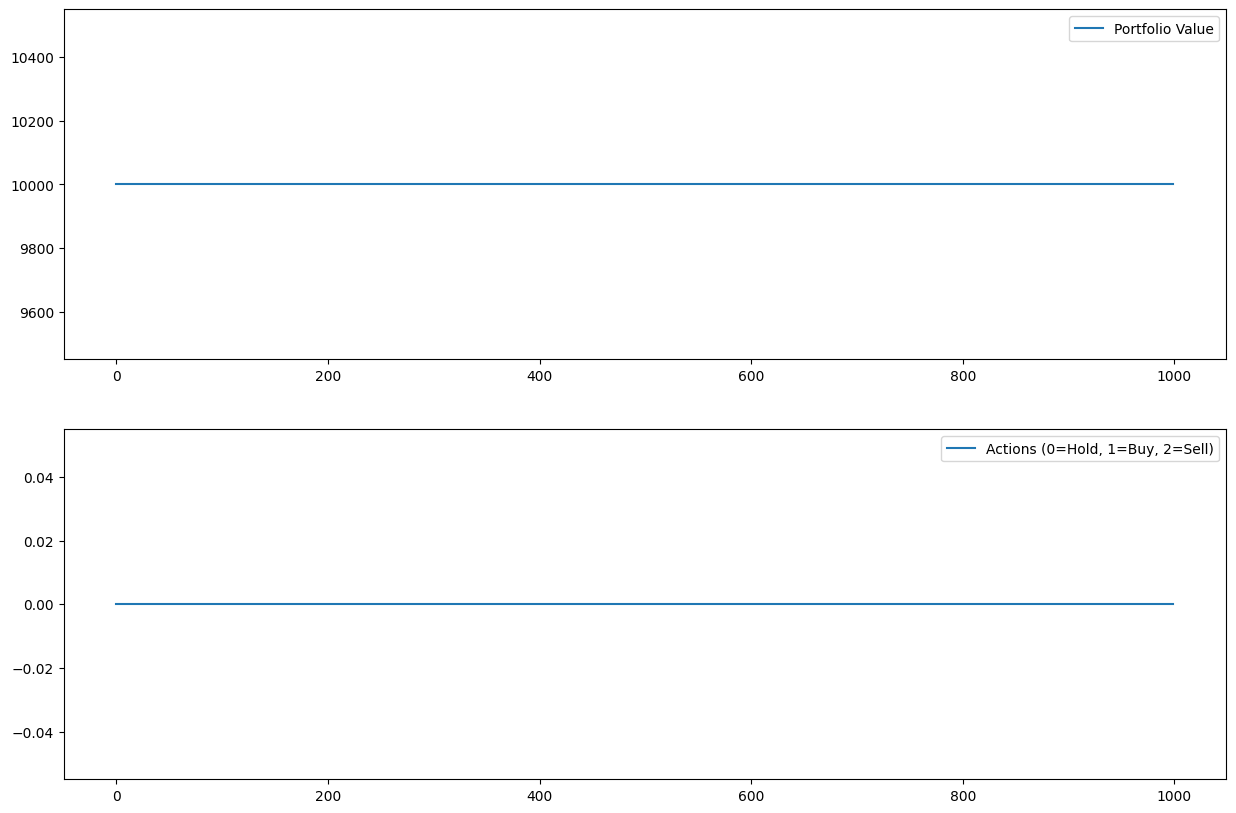

Action distribution: Counter({0: 1000})


In [13]:
env = TradingEnv(df)
state, _ = env.reset()  # Unpack correctly
portfolio_values = []
actions_taken = []

while True:
    # Use only the observation part for model prediction
    action, _ = model.predict(state, deterministic=True)  # Unpack action
    actions_taken.append(int(action))  # Track actions

    n_state, reward, done, _, info = env.step(action)
    portfolio_values.append(info["net_worth"])  # Track portfolio
    state = n_state

    if done:
        print("Final info:", info)
        break

# Plot results
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(portfolio_values, label='Portfolio Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(actions_taken, label='Actions (0=Hold, 1=Buy, 2=Sell)')
plt.legend()
plt.show()

# Print action distribution
from collections import Counter
print("Action distribution:", Counter(actions_taken))